# __Scenario A:__<br>Chymotrypsin inhibiton by a designed albumin fusion protein

Data provided by Marwa Mohamed (Institute of Cell Biology and Immunology, University of Stuttgart, Stuttgart, Germany)

## Project background
In this scenaro, the inhibitory effect of a human serum albumin mutant on chymotrypsin was investigated. Thereby, the inhibition constant $K_{i}$ of the HSA wild-type was compared to HSA(M3) mutant. Both HSAs were individually dimerized into fusion proteins through a huFc.  
Experimental data from the HSA(wt)-huFc and HSA(M3)-huFc originate from two independent experiments. In each experiment the initial substrate concentration was varied. Once with the respective inhibitor, and once without. Therefore, $K_{i}$ and $K_{m}$ were determined indenpendently from each other. Additionally, each individual reaction condition was prepared in duplicates to ensure repeatability.  
Since 

### Experimental design

In order to assess the effect of the introduced mutations to the HSA(M3) variant, $K_{i}$ of the HSA wild-type was compared to HSA(M3) variant. Enzyme activity was monitored by measuring the product formation of p-Nitroanilin (p-NA) photometrically at 410 nm for 30 min at 30°C. Therefore,  Succinyl-gly-gly-phe-p-nitroanilide (SGGPpNA) was applied as substrate in a concentration range of 0.25 - 2 mM. For concentration calculations, p-NA standard was prepared in the range of 0 - 0.3 mM in duplicates. $K_{i}$ of HSA(wt) and HSA(M3) on chymotrypsin were investigated in independent experiments. Each experiment consisted of enzyme reactions with and without the respective HSA variant. The enzyme reactions contined dfhdfhdfh µM of enzyme and 26.88 µM of the respective HSA variant, if applied.

### Data management

Experimental data and meta data was filled in EnzymeML Excel templates for each of the two inhibition experiments respectively. Calibration data was stored as Excel files. Measurement data was already blanked.

## Data preparation

### Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyenzyme as pe
import copy
from IPython.display import display
from EnzymePynetics.tools.parameterestimator import ParameterEstimator
from CaliPytion.tools.standardcurve import StandardCurve

import warnings
warnings.filterwarnings('ignore')

### Concentration calculation

Product standard data was imported directly from an Excel file. Then, a standard curve was created.

Calibration data was automatically blanked.


,AIC
Quadratic,-161
3rd polynominal,-161
Linear,-143
Rational,-141
Exponential,-17


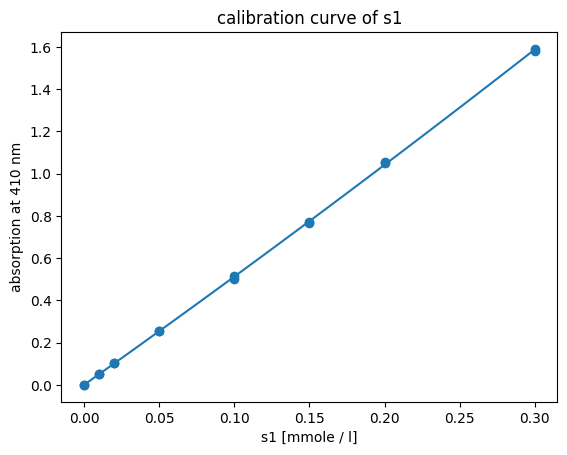

In [2]:
product_standard = StandardCurve.from_excel(
    path="../../data/chymotrypsin_inhibition/pNA-standard.xlsx",
    reactant_id="s1",
    wavelength=410,
    sheet_name="csv", 
    concentration_unit="mmole / l",
    temperature=30,
    temperature_unit="C")
    
product_standard.visualize()

Based on the Akaike information criterion (AIC), the relation between concentration and absorption is best described by a quadratic function. The figure above visualizes the calibration measurements and the fitted calibration model.

### Experimantal data

The EnzymeML documents were loaded and the standard curve was applied to the absorption data for concentration calculation.

In [3]:
# Load data from 
chymo_HSAwt = pe.EnzymeMLDocument.fromTemplate("../../data/chymotrypsin_inhibition/chymo_HSAwt.xlsx")
chymo_HSAM3 = pe.EnzymeMLDocument.fromTemplate("../../data/chymotrypsin_inhibition/chymo_HSA(M3).xlsx")

# Apply standard curve to 'EnzymeMLDocument'
chymo_HSAwt = product_standard.apply_to_EnzymeML(chymo_HSAwt, "s1")
chymo_HSAM3 = product_standard.apply_to_EnzymeML(chymo_HSAM3, "s1")

## Comparability of the experiments

Since the experimental data from the HSA wild-type and the HSA(M3) variant originate from independent experiments, the control reactions without the respective inhibitor were compared by performing a parameter estimation. Thereby, $k_{cat}$ and $K_{m}$ were highly correlated (corr > 0.98). Hence, catalytic efficiency $\frac{k_{cat}}{K_{m}}$ was used to assess comparability between the data sets. High correlation indicates, that the highest initial substrate concentration is too low, compared to the true $K_{m}$ of the enzyme under the given experimental conditions. In this case, higher substrate concentration were not applied for multiple reasons. On the one hand dimethyl sulfoxide (DMSO) was used as a co-solvent of the substrate, which inhibits enzyme activity {cite:t}`busby1999effect`. Hence, higher initial substrate concentrations would have led to higher enzyme inhibition. On the other hand, high substrate viscosity denied the application of higher concentrations without sacrificing pipetting percision.

Kinetic parameters of HSA(wt) chymotrypsin control reactions:


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
irreversible Michaelis Menten,-1857,56.440 +/- 4.52%,2.226 +/- 7.28%,25.353 +/- 8.57%,-,-
competitive product inhibition,-1856,60.225 +/- 9.01%,2.342 +/- 9.88%,25.714 +/- 13.37%,0.725 +/- 112.65%,-
uncompetitive product inhibition,-1855,57.529 +/- 8.30%,2.276 +/- 10.65%,25.272 +/- 13.50%,-,3.175 +/- 428.92%
substrate inhibition,-1855,56.585 +/- 29.14%,2.233 +/- 35.51%,25.339 +/- 45.93%,-,997.715 +/- 12275.11%
non-competitive product inhibition,-1854,60.110 +/- 9.50%,2.331 +/- 10.00%,25.787 +/- 13.79%,0.702 +/- 117.81%,179.118 +/- 358.38%



Kinetic parameters of HSA(M3) chymotrypsin control reactions:


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
irreversible Michaelis Menten,-549,48.996 +/- 2.23%,1.978 +/- 3.74%,24.776 +/- 4.35%,-,-
competitive product inhibition,-549,51.227 +/- 4.39%,2.043 +/- 4.76%,25.077 +/- 6.47%,0.908 +/- 81.63%,-
uncompetitive product inhibition,-547,49.384 +/- 5.33%,1.996 +/- 6.71%,24.743 +/- 8.57%,-,7.445 +/- 631.41%
non-competitive product inhibition,-547,51.241 +/- 5.62%,2.044 +/- 6.62%,25.073 +/- 8.69%,0.914 +/- 83.56%,121.556 +/- 2156.85%
substrate inhibition,-545,50.368 +/- 3.78%,2.046 +/- 5.12%,24.623 +/- 6.36%,-,87.549 +/- 121.66%


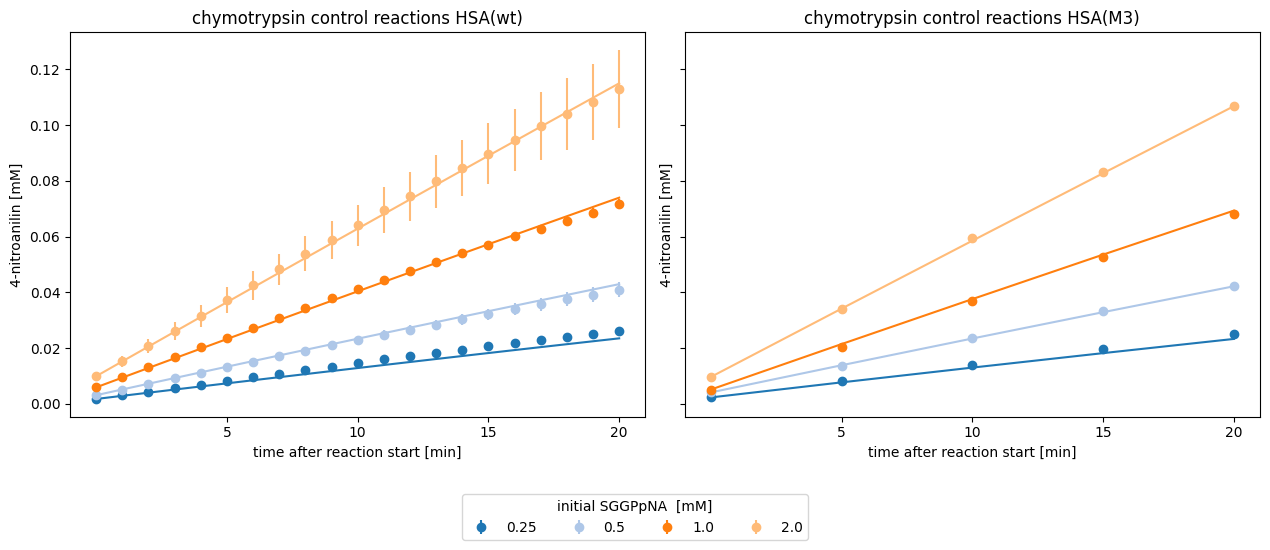

In [24]:
# Create copys of the data sets and delete measuremnts with inhibitor.
wt_control = copy.deepcopy(chymo_HSAwt)
del wt_control.measurement_dict["m4"]
del wt_control.measurement_dict["m5"]
del wt_control.measurement_dict["m6"]
del wt_control.measurement_dict["m7"]

m3_control = copy.deepcopy(chymo_HSAM3)
del m3_control.measurement_dict["m4"]
del m3_control.measurement_dict["m5"]
del m3_control.measurement_dict["m6"]
del m3_control.measurement_dict["m7"]

# Estimate kinetic parameters of the control reactions of the HSA wild-type data set.
kinetics_wt_control = ParameterEstimator.from_EnzymeML(wt_control, "s1", "product")
kinetics_wt_control.fit_models(stop_time_index=-1, display_output=False)
print("Kinetic parameters of HSA(wt) chymotrypsin control reactions:")
display(kinetics_wt_control.result_dict.drop(columns=["kcat [1/min]", ]))

# Estimate kinetic parameters of the control reactions of the HSA(M3) data set.
kinetics_m3_control = ParameterEstimator.from_EnzymeML(m3_control, "s1", "product")
kinetics_m3_control.fit_models(stop_time_index=-1, display_output=False)
print("\nKinetic parameters of HSA(M3) chymotrypsin control reactions:")
display(kinetics_m3_control.result_dict)


fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=True, sharex=True)
for e, (doc, ax, title) in enumerate(zip([kinetics_wt_control ,kinetics_m3_control], axes.flatten(), ["chymotrypsin control reactions HSA(wt)", "chymotrypsin control reactions HSA(M3)"])):
    doc.visualize(ax=ax, title=title)
    ax.set_ylabel("4-nitroanilin [mM]")
    ax.set_xlabel("time after reaction start [min]")
    ax.set_xticks([5, 10, 15, 20])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc="lower center", ncol=4, title="initial SGGPpNA  [mM]", bbox_to_anchor=(0.5,-0.15))
plt.tight_layout()


_Fig. 1: Measurement data and fitted irreversible Michaelis-Menten model for chymotrypsin reactions without HSA inhibitor._

The above figure visualizes the control reactions of each HSA inhibition experiment. Each dataset was fitted against the models listed in the above table. 
Each dataset is best described by the irreversible Michaelis-Menten model in therms of AIC and standard deviation on the estimated parameters. Models with product or substrate inhibition resulted in large uncertanties above 80 % on the parameter estimates. Thus, substrate and product inhibition were ruled out for the given reactions.  $\frac{k_{cat}}{K_{m}}$ was estimated to be 25.353 min<sup>-1</sup>mM<sup>-1</sup> ± 8.57%  for the control reaction of the HSA(wt) data set and 24.776 min<sup>-1</sup>mM<sup>-1</sup> ± 4.35% for the HSA(M3) data set. As a result, the two experiments showed to be comparable, since the catalytic efficiency differs less than 3 % between the two data sets.

## Determination and comparison of $K_{i}$

The data set of chymotrypsin inhibition by HSA(M3) contained negative absorption values for the first measurement point. Presumably from an incorrect blank measurement. Therefore, only measurement data from the second data point (minute 5 and onward) was considered for parameter estimation. Additionally, measuremet
The tables below show the parameter estimastes for all applied kinetic models.

Kinetic parameters estimates for all models of chymotrypsin inhibition by HSA(wt):


,AIC,kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
competitive inhibition,-3100,22.253 +/- 6.97%,0.460 +/- 27.24%,-
non-competitive inhibition,-3098,22.403 +/- 7.00%,0.449 +/- 27.64%,79.193 +/- 516.52%
irreversible Michaelis Menten,-3088,21.622 +/- 7.15%,-,-
uncompetitive inhibition,-3087,21.631 +/- 7.63%,-,0.696 +/- 88.99%
partially competitive inhibition,-3084,21.643 +/- 8.23%,796.196 +/- 1075.02%,992.685 +/- 48.74%



Kinetic parameters estimates for all models of chymotrypsin inhibition by HSA(M3):


,AIC,kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
competitive inhibition,-808,23.031 +/- 10.48%,0.059 +/- 8.51%,-
non-competitive inhibition,-806,23.002 +/- 10.89%,0.060 +/- 9.04%,44.965 +/- 302.77%
uncompetitive inhibition,-751,19.297 +/- 21.77%,-,0.035 +/- 21.33%
irreversible Michaelis Menten,-713,18.512 +/- 24.41%,-,-
partially competitive inhibition,-709,18.544 +/- 27.64%,569.354 +/- 57.96%,925.096 +/- 11733.22%


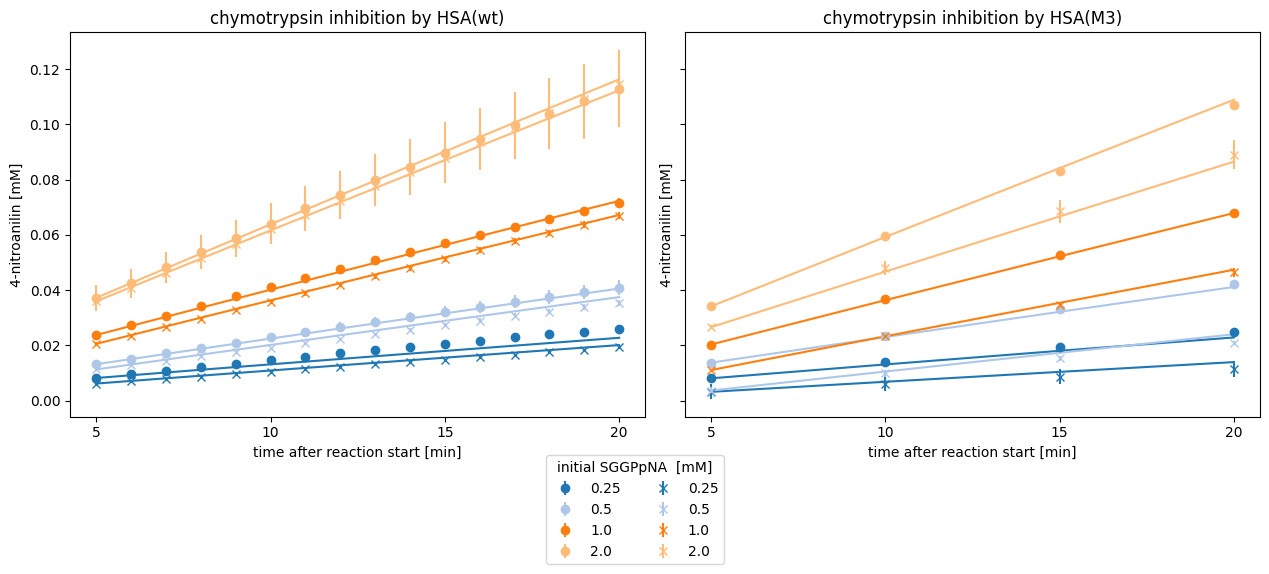

In [40]:
# Parameter estimation for HSA(wt) data set
kinetics_HSAwt = ParameterEstimator.from_EnzymeML(chymo_HSAwt, reactant_id="s1", inhibitor_id="s2", measured_species="product")
kinetics_HSAwt.fit_models(initial_substrate_concs=[0.25, 0.5, 1, 2], stop_time_index=-1, start_time_index=5, display_output=False)
print("Kinetic parameters estimates for all models of chymotrypsin inhibition by HSA(wt):")
display(kinetics_HSAwt.result_dict.drop(columns=["kcat [1/min]", "Km [mmole / l]"]))

# Parameter estimation for HSA(M3) data set
kinetics_HSAM3 = ParameterEstimator.from_EnzymeML(chymo_HSAM3, reactant_id="s1", inhibitor_id="s3", measured_species="product")
kinetics_HSAM3.fit_models(initial_substrate_concs=[0.25, 0.5, 1, 2], stop_time_index=-1, start_time_index=1, display_output=False)
print("\nKinetic parameters estimates for all models of chymotrypsin inhibition by HSA(M3):")
display(kinetics_HSAM3.result_dict.drop(columns=["kcat [1/min]", "Km [mmole / l]"]))

# Visualize experimental data and fitted models
fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=True, sharex=True)
for e, (doc, ax, title) in enumerate(zip([kinetics_HSAwt ,kinetics_HSAM3], axes.flatten(), ["chymotrypsin inhibition by HSA(wt)", "chymotrypsin inhibition by HSA(M3)"])):
    doc.visualize(ax=ax, title=title)
    ax.set_ylabel("4-nitroanilin [mM]")
    ax.set_xlabel("time after reaction start [min]")
    ax.set_xticks([5, 10, 15, 20])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc="lower center", ncol=2, title="initial SGGPpNA  [mM]", bbox_to_anchor=(0.5,-0.2))
plt.tight_layout()

_Fig. 1: Measurement data and fitted product inhibition model for chymotrypsin reactions with respective HSA inhibitior._

Both reaction systems are best described by the competitive inhibition model, which is indicated by the lowest AIC and standard deviation on the estimated parameters. Thereby, a $K_{i}$ of 0.460 mM ± 27.24% was estimated for HSA(wt) and 0.059 mM ± 8.51% for HSA(M3). This resembles a roughly 7-fold increase in affinity of HSA(M3) to the enzyme compared to the HSA(wt). Since the competitive inhibition model describes the data the best, HSA(M3) presumably interactis with the enzyme in the active site region.  